Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

<h2>Data Dictionary</h2>
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

<h2>Variable Notes</h2>

<b>pclass</b>: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

<b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

<b>sibsp</b>: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

<b>parch</b>: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = train.drop(['Survived'], axis=1)
PassengerId = test['PassengerId']

In [61]:
y_train = train['Survived']
train_num = len(train)
clf = LogisticRegression(solver='lbfgs', max_iter =200)
gbc = GradientBoostingClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

In [62]:
print(f'''{len(df.columns)} features in dataset. 
Features: {df.columns.values}''')

11 features in dataset. 
Features: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [63]:
df = pd.concat([df,test],ignore_index=True)
df.shape

(1309, 11)

In [64]:
df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [66]:
print('Ticket class:', set(df.Pclass))
print('SibSp: # of siblings / spouses aboard the Titanic:', set(df.SibSp))
print('Parch: # of parents / children aboard the Titanic:', set(df.Parch))
print('Port of Embarkation:',set(df['Embarked']))

Ticket class: {1, 2, 3}
SibSp: # of siblings / spouses aboard the Titanic: {0, 1, 2, 3, 4, 5, 8}
Parch: # of parents / children aboard the Titanic: {0, 1, 2, 3, 4, 5, 6, 9}
Port of Embarkation: {'S', nan, 'Q', 'C'}


In [67]:
obj_features = []
num_features = []
for dtype,feature in zip(df.dtypes, df.columns):
    if dtype == 'object':
        obj_features.append(feature)
    else:
        num_features.append(feature)
print(f'''Object Features: {obj_features}
Numeric Features: {num_features}''')

Object Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [68]:
# Name to title
df['title'] = df['Name'].apply(lambda x: x.split(',')[1])
df['title'].head()

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
3             Mrs. Jacques Heath (Lily May Peel)
4                              Mr. William Henry
Name: title, dtype: object

In [69]:
df['title'] = df['title'].apply(lambda x: x.split('.')[0].strip())
df['title'].head(20)
df['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Sir               1
the Countess      1
Dona              1
Mme               1
Jonkheer          1
Lady              1
Capt              1
Don               1
Name: title, dtype: int64

In [70]:
df['Cabin'].iloc[1][0]

'C'

In [71]:
# Title Group
title_group = {
 'Mr':'Mr',
 'Miss':'Miss',
 'Mrs':'Mrs',
 'Master':'upper',
 'Dr':'upper',
 'Rev':'soldier',
 'Col':'soldier',
 'Mlle':'Miss',
 'Ms':'Mrs',
 'Major':'soldier',
 'Don':'royal',
 'Jonkheer':'royal',
 'Mme':'Mrs',
 'Sir':'soldier',
 'Lady':'royal',
 'the Countess':'royal',
 'Dona':'royal',
 'Capt':'soldier'
}

df['title'] = df['title'].map(title_group)
df['title'].value_counts()

Mr         757
Miss       262
Mrs        200
upper       69
soldier     16
royal        5
Name: title, dtype: int64

In [72]:
group3 = df.groupby(['Sex','Pclass','title'])
group3['Age'].median()

Sex     Pclass  title  
female  1       Miss       30.0
                Mrs        45.0
                royal      39.0
                upper      49.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Mr         41.5
                royal      39.0
                soldier    52.5
                upper      13.0
        2       Mr         30.0
                soldier    41.5
                upper       2.0
        3       Mr         26.0
                upper       6.0
Name: Age, dtype: float64

In [73]:
df['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [74]:
# Fill NA
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Age'] =group3['Age'].apply(lambda x: x.fillna(x.median()))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Cabin'] = df['Cabin'].fillna('U')

In [75]:
# Cabin Catagories
df['Cabin'] = df['Cabin'].apply(lambda x: x[0])
df['Cabin'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

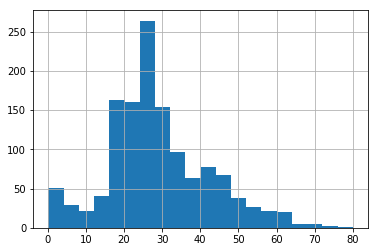

In [76]:
df.Age.hist(bins=20)

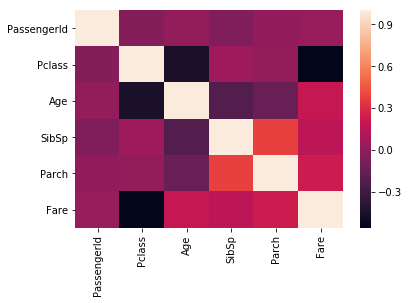

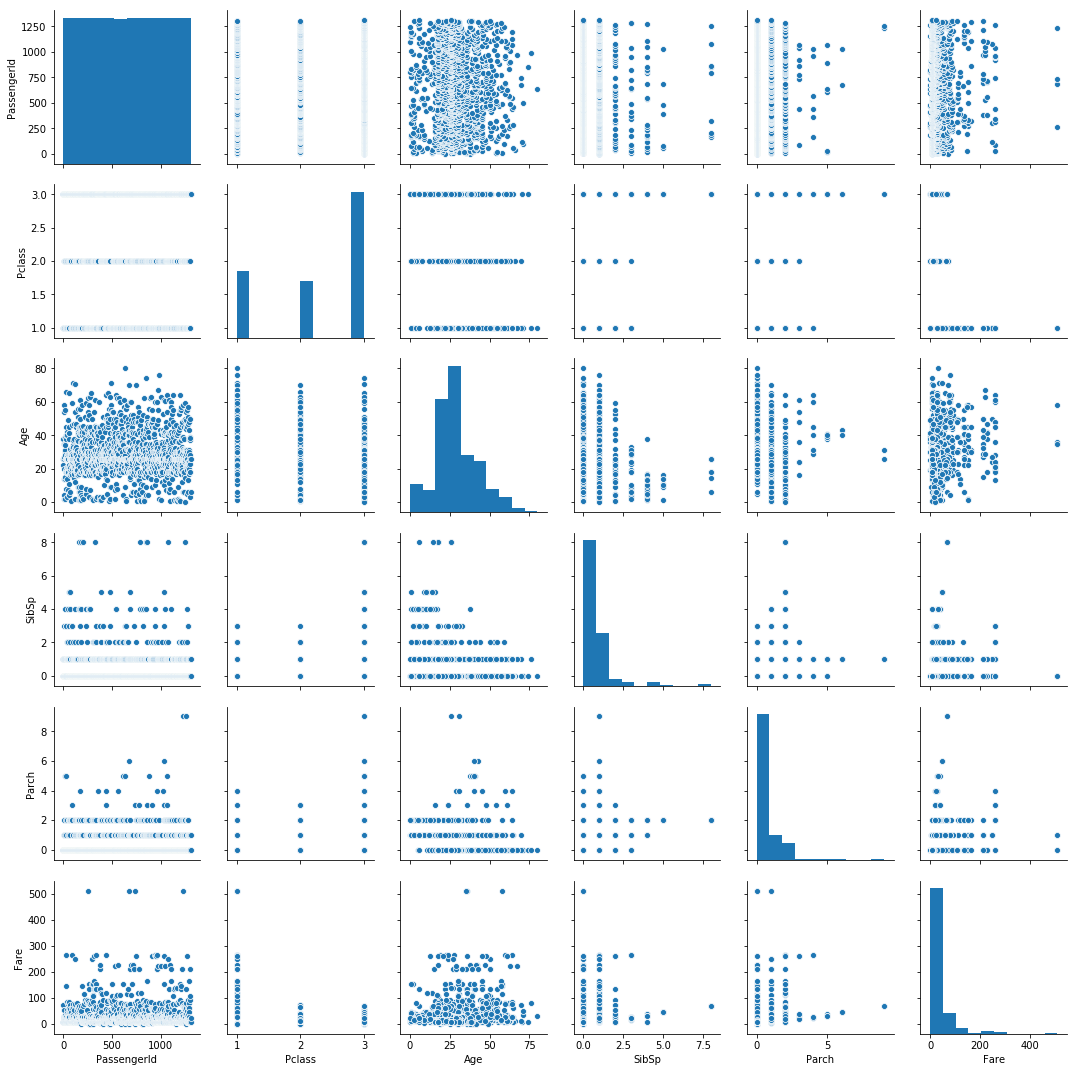

In [77]:
corr = df.corr()
sns.heatmap(corr)
plt.show()
sns.pairplot(df)
plt.show()

In [78]:
df.Age.describe()

count    1309.000000
mean       29.248411
std        13.439512
min         0.170000
25%        21.000000
50%        26.000000
75%        36.500000
max        80.000000
Name: Age, dtype: float64

In [79]:
df['Age_group'] = pd.cut(df['Age'], [0,15,60,90])

In [80]:
df= df.join(pd.get_dummies(df['Age_group'],prefix='Age_group')) # One-Hot Encoding for Pclass
df= df.join(pd.get_dummies(df['Sex'],prefix='Sex')) # One-Hot Encoding for Sex
df= df.join(pd.get_dummies(df['SibSp'],prefix='SibSp')) # One-Hot Encoding for SibSp
df= df.join(pd.get_dummies(df['Parch'],prefix='Parch')) # One-Hot Encoding for Parch
df= df.join(pd.get_dummies(df['Embarked'],prefix='Embarked')) # One-Hot Encoding for Embarked
df= df.join(pd.get_dummies(df['title'],prefix='title')) # One-Hot Encoding for title
df= df.join(pd.get_dummies(df['Cabin'],prefix='Cabin')) # One-Hot Encoding for Cabin

In [81]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'title', 'Age_group',
       'Age_group_(0, 10]', 'Age_group_(10, 70]', 'Age_group_(70, 90]',
       'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_royal', 'title_soldier', 'title_upper', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_U'],
      dtype='object')

In [82]:
df = df.drop(['Name','Age','Age_group','Sex','SibSp','Parch','Embarked','title','Cabin'],axis =1)

In [83]:
# df['Fare']= MinMaxScaler.fit_transform(df['Fare'])

In [84]:
df.columns
df.head()

,PassengerId,Pclass,Ticket,Fare,"Age_group_(0, 10]","Age_group_(10, 70]","Age_group_(70, 90]",Sex_female,Sex_male,SibSp_0,...,title_upper,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,3,A/5 21171,7.2500,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,PC 17599,71.2833,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,3,STON/O2. 3101282,7.9250,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,113803,53.1000,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,3,373450,8.0500,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [85]:
df_comb = df.drop('PassengerId',axis=1)
df_comb.head()
num_features = []
for dtype, feature in zip(df_comb.dtypes, df_comb.columns):
    if dtype != 'object':
        num_features.append(feature)
X_train = df_comb[num_features][:train_num]
X_test = df_comb[num_features][train_num:]
len(num_features)

40

In [86]:
X_test.describe()

,Pclass,Fare,"Age_group_(0, 10]","Age_group_(10, 70]","Age_group_(70, 90]",Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,title_upper,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000
mean,2.265550,35.576535,0.062201,0.935407,0.002392,0.363636,0.636364,0.677033,0.263158,0.033493,...,0.052632,0.016746,0.043062,0.083732,0.031100,0.021531,0.019139,0.002392,0.0,0.782297
std,0.841838,55.850103,0.241810,0.246101,0.048912,0.481622,0.481622,0.468170,0.440875,0.180135,...,0.223564,0.128474,0.203240,0.277317,0.173797,0.145320,0.137177,0.048912,0.0,0.413179
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.000000,7.895800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
50%,3.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,3.000000,31.471875,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,3.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [87]:
# cross_val_score(clf,X_train, y_train, cv=5).mean()

In [88]:
# cross_val_score(gbc,X_train, y_train, cv=10).mean()

In [89]:
# cross_val_score(dtc,X_train,y_train, cv=10).mean()

In [90]:
# cross_val_score(rfc,X_train,y_train, cv=10).mean()

In [91]:
parameters = dict(
    max_depth =[i for i in range(9,16)],
    min_samples_split = [i for i in range (4,11)],
    min_samples_leaf = [i for i in range (2,5)],
    n_estimators = [i for i in range(10,50,10)]
)

In [92]:
rfc_cv = GridSearchCV(estimator=rfc,
                     param_grid = parameters, cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [9, 10, 11, 12, 13, 14, 15], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4], 'n_estimators': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
print(f'Best Score: {rfc_cv.best_score_}')
print(f'Best Parameters: {rfc_cv.best_estimator_}')

Best Score: 0.835016835016835
Best Parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [94]:
prediction = rfc_cv.predict(X_test)

In [95]:
result = pd.DataFrame({'PassengerId': PassengerId,
                       'Survived': prediction})
result.to_csv('./titanic_pred.csv', index=False)